# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS109B Data Science 2: Advanced Topics in Data Science 

## Homewor: Inference in NN 

**Harvard University**<br/>
**Spring 2020**<br/>
**Instructors:** Pavlos Protopapas, Mark Glickman, Chris Tanner<br/>

<hr style="height:2pt">

In [1]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get("https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css").text
HTML(styles)

In [2]:
#RUN THIS CELL
import os
import pathlib
working_dir = pathlib.Path().absolute()
os.chdir(working_dir)

<hr style="height:2pt">

### INSTRUCTIONS

- To submit your assignment follow the instructions given in Canvas.

- This homework can be submitted in pairs.

- Please restart the kernel and run the entire notebook again before you submit.

<hr style="height:2pt">

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# from sklearn.preprocessing import StandardScaler

sns.set()

import tensorflow as tf

import tensorflow.keras.backend as K
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, History 
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
#from tensorflow.keras.utils import np_utils
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.layers import Dropout
from sklearn.model_selection import cross_val_score,  KFold, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from tensorflow.keras import optimizers

from functools import partial

np.random.seed(0)


%matplotlib notebook
%matplotlib inline

<div class="theme"> Overview </div> 

In this homework, we will investigate methods for uncertainty quantification in deep neural networks. These are alternatives to the robust MCMC that doesn't scale to large models.

<div class='exercise'><b> Question 1: Dropout as a Bayesian Approximation [10 pts] (Gal & Ghahramani 2015, https://arxiv.org/abs/1506.02142)</b></div>  

For this question, we will be generate a synthetic dataset in order to be able to test different uncertainty regimes, we will train the model with a gap in the data. 

**1.1** [1 pt] Generate a synthetic two dimensional dataset using the function y = 0.1 * x^3 plus random noise (0, 0.25). Generate a training set of 200 points with no data in the range x=[-1,1]. Generate a test set of 80 data points with values uniformly distributed in the whole domain. Plot the two data sets.

**1.2** [2 pts] Create a fully connected neural network with 3 layers of 20 nodes each. Include dropout (using the Dropout class provided) before the last layer. 

**1.3** [2 pts] Train the network with dropout of 0.1, do inference for all the test points 10 times in training mode. From the outputs, find the model mean and standard variation. Repeat with dropoout of 0.2.

**1.4** [1 pt] Make a plot of the data, the model, and the uncertainty. Show the model mean and color the region of tow standard deviations.

**1.5** [2 pts] Turn dropout off (set it to 0) and train 50 models bootstrapping the training data. Doing statistics on the outputs, make a plot of the data, the model, and the uncertainty. Show the model mean and color the region two standard deviations away, as in **1.3**

**1.6** [2 pts] Compare both methods and discuss the pros and cons of each.



## Answers

**1.1** [1 pt] Generate a synthetic two dimensional dataset using the function y = 0.1 * x^3 plus random noise (0, 0.25). Generate a training set of 200 points with no data in the range x=[-1,1]. Generate a test set of 80 data points with values uniformly distributed in the whole domain. Plot the two data sets.


In [4]:
def build_dataset(N, noise_std=0.25, is_test=True):
    # your code here
    if is_test:
        X = np.random.random(size = N) * 8 - 4 # unif(-4,4)      
    else:
        choices = np.random.random(size = N)
        N_small = sum(choices < 0.5)
        N_large = N - N_small
        X = np.concatenate((np.random.random(size = N_small) * 3 - 4, #unif(-4,-1)
                     np.random.random(size = N_large) * 3 + 1)) #unif(1,4)
        
    Y = 0.1 * (X**3) + np.random.random(size = N)* noise_std
    return(np.array((X,Y)).T)

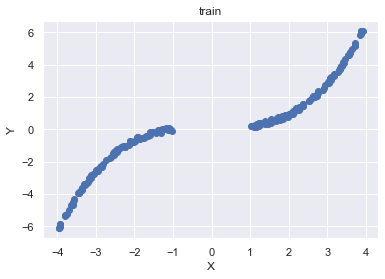

In [5]:
# your code here
data_train = build_dataset(200, is_test = False)
plt.scatter(data_train[:, 0], data_train[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('train')
plt.show()

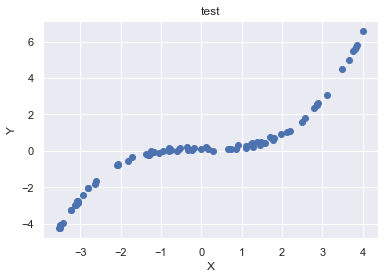

In [6]:
data_test = build_dataset(80)
plt.scatter(data_test[:, 0], data_test[:, 1])
plt.xlabel('X')
plt.ylabel('Y')
plt.title('test')
plt.show()

In [7]:
# your code here
data_train = data_train.reshape(200, 2, -1)
data_test = data_test.reshape(80, 2, -1)

**1.2** [2 pts] Create a fully connected neural network with 3 layers of 20 nodes each. Include dropout (using the Dropout class provided) before the last layer.


In [8]:
# https://github.com/keras-team/keras/issues/9412

class Dropout(layers.Dropout):
    """Applies Dropout to the input.
    Dropout consists in randomly setting
    a fraction `rate` of input units to 0 at each update during training time,
    which helps prevent overfitting.
    # Arguments
        rate: float between 0 and 1. Fraction of the input units to drop.
        noise_shape: 1D integer tensor representing the shape of the
            binary dropout mask that will be multiplied with the input.
            For instance, if your inputs have shape
            `(batch_size, timesteps, features)` and
            you want the dropout mask to be the same for all timesteps,
            you can use `noise_shape=(batch_size, 1, features)`.
        seed: A Python integer to use as random seed.
    # References
        - [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](
           http://www.jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)
    """
    def __init__(self, rate, training=None, noise_shape=None, seed=None, **kwargs):
        super(Dropout, self).__init__(rate, noise_shape=None, seed=None,**kwargs)
        self.training = training

        
    def call(self, inputs, training=None):
        if 0. < self.rate < 1.:
            noise_shape = self._get_noise_shape(inputs)

            def dropped_inputs():
                return K.dropout(inputs, self.rate, noise_shape,
                                 seed=self.seed)
            if not training: 
                return K.in_train_phase(dropped_inputs, inputs, training=self.training)
            return K.in_train_phase(dropped_inputs, inputs, training=training)
        return inputs

In [9]:
# create model 
# your code here 
model = Sequential()
model.add(Dense(20, activation = 'relu', input_shape = (1,)))
model.add(Dense(20, activation = 'relu'))
model.add(Dense(20, activation = 'relu'))
model.add(Dropout(0.1, training = True))
model.add(Dense(1, activation = 'linear'))
model.compile(loss = 'mse', optimizer = Adam(lr = 0.002))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 20)                420       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                420       
_________________________________________________________________
dropout (Dropout)            (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 901
Trainable params: 901
Non-trainable params: 0
_________________________________________________________________


In [10]:
# Fit the model
# your code here
model.fit(x = data_train[:, 0],
          y = data_train[:, 1],
          batch_size = 32,
          validation_data = (data_test[:, 0], data_test[:, 1]),
          epochs = 50)

Train on 200 samples, validate on 80 samples
Epoch 1/50
200/200 [==============================] - 2s 10ms/sample - loss: 6.6910 - val_loss: 4.2085
Epoch 2/50
200/200 [==============================] - 0s 587us/sample - loss: 5.4429 - val_loss: 3.2917
Epoch 3/50
200/200 [==============================] - 0s 573us/sample - loss: 4.4559 - val_loss: 2.5437
Epoch 4/50
200/200 [==============================] - 0s 538us/sample - loss: 3.5561 - val_loss: 1.8908
Epoch 5/50
200/200 [==============================] - 0s 502us/sample - loss: 2.5031 - val_loss: 1.4333
Epoch 6/50
200/200 [==============================] - 0s 514us/sample - loss: 1.8727 - val_loss: 1.5686
Epoch 7/50
200/200 [==============================] - 0s 502us/sample - loss: 1.6536 - val_loss: 1.3695
Epoch 8/50
200/200 [==============================] - 0s 492us/sample - loss: 1.5921 - val_loss: 0.9997
Epoch 9/50
200/200 [==============================] - 0s 553us/sample - loss: 1.3572 - val_loss: 1.1098
Epoch 10/50
200/200 

In [11]:
# evaluate the training and testing performance of your model 
# your code here
train_pred = model.predict(data_train[:, 0]).flatten()
test_pred = model.predict(data_test[:, 0]).flatten()

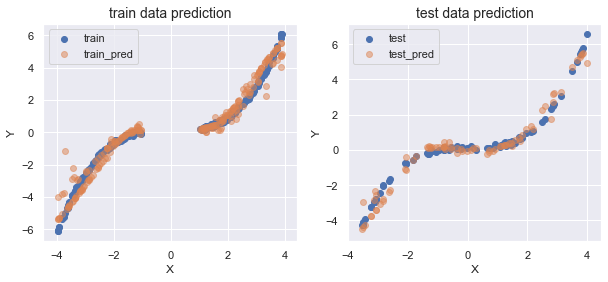

In [12]:
# plot 
# your code here 
# sort data
x_train_order = np.argsort(data_train[:, 0].flatten())
x_test_order = np.argsort(data_test[:, 0].flatten())

x_train = data_train[:, 0].flatten()[x_train_order]
x_test = data_test[:, 0].flatten()[x_test_order]
y_train = data_train[:, 1].flatten()[x_train_order]
y_test = data_test[:, 1].flatten()[x_test_order]
# plot
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.scatter(x_train, y_train, label = 'train')
plt.scatter(x_train, train_pred[x_train_order], alpha = 0.5, label = 'train_pred')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('train data prediction', size = 14)
plt.legend()

plt.subplot(122)
plt.scatter(x_test, y_test, label = 'test')
plt.scatter(x_test, test_pred[x_test_order], alpha = 0.5, label = 'test_pred')
plt.xlabel('X')
plt.ylabel('Y')
plt.title('test data prediction', size = 14)
plt.legend()
plt.show()

**1.3** [2 pts] Train the network with dropout of 0.1, do inference for all the test points 10 times in training mode. From the outputs, find the model mean and standard variation. Repeat with dropoout of 0.2.


In [21]:
# your code here
model1 = Sequential()
model1.add(Dense(20, activation = 'relu', input_shape = (1,)))
model1.add(Dense(20, activation = 'relu'))
model1.add(Dense(20, activation = 'relu'))
model1.add(Dropout(0.1, training = True))
model1.add(Dense(1, activation = 'linear'))
model1.compile(loss = 'mse', optimizer = Adam(lr = 0.002))
# train
model1.fit(x = data_train[:, 0],
          y = data_train[:, 1],
          batch_size = 32,
          validation_data = (data_test[:, 0], data_test[:, 1]),
          epochs = 50,
          verbose = False)
# predict 10 times
test_pred = []
for i in range(10):
    test_pred.append(model1.predict(data_test[:, 0]))
test_all = np.concatenate(test_pred, axis = 1)
# mean and variance
model1_mean = np.mean(test_all, axis = 1)
model1_sd = np.std(test_all, axis = 1)

In [23]:
# your code here
model2 = Sequential()
model2.add(Dense(20, activation = 'relu', input_shape = (1,)))
model2.add(Dense(20, activation = 'relu'))
model2.add(Dense(20, activation = 'relu'))
model2.add(Dropout(0.2, training = True))
model2.add(Dense(1, activation = 'linear'))
model2.compile(loss = 'mse', optimizer = Adam(lr = 0.002))
# train
model2.fit(x = data_train[:, 0],
          y = data_train[:, 1],
          batch_size = 32,
          validation_data = (data_test[:, 0], data_test[:, 1]),
          epochs = 50,
          verbose = False)
# predict 10 times
test_pred = []
for i in range(10):
    test_pred.append(model2.predict(data_test[:, 0]))
test_all = np.concatenate(test_pred, axis = 1)
# mean and variance
model2_mean = np.mean(test_all, axis = 1)
model2_sd = np.std(test_all, axis = 1)

**1.4** [1 pt] Make a plot of the data, the model, and the uncertainty. Show the model mean and color the region of tow standard deviations.


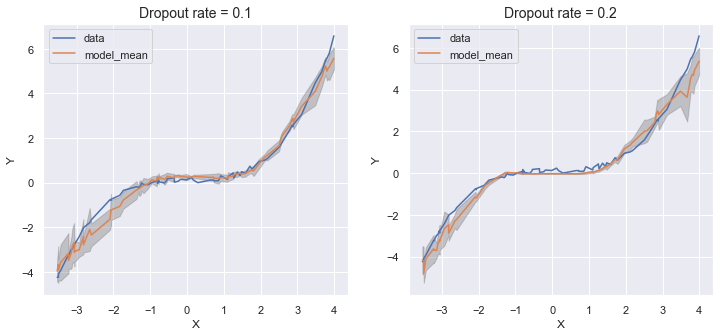

In [24]:
# plot 
# your code here
# sort prediction data
model1_test_mean = model1_mean[x_test_order]
model1_test_sd  = model1_sd[x_test_order]
model2_test_mean =model2_mean[x_test_order]
model2_test_sd  = model2_sd[x_test_order]
# plot
plt.figure(figsize=(12,5))
plt.subplot(121)
plt.plot(x_test, y_test, label = 'data')
plt.plot(x_test, model1_test_mean, label = 'model_mean')
plt.fill_between(x_test, model1_test_mean - 1 * model1_test_sd, 
                 model1_test_mean + 1 * model1_test_sd,
                 color='gray', alpha=0.4)
plt.xlabel('X')
plt.ylabel('Y')
plt.legend()
plt.title('Dropout rate = 0.1', size = 14)

plt.subplot(122)
plt.plot(x_test, y_test, label = 'data')
plt.plot(x_test, model2_test_mean, label = 'model_mean')
plt.fill_between(x_test, model2_test_mean - 1 * model2_test_sd, 
                 model2_test_mean + 1 * model2_test_sd,
                 color='gray', alpha=0.4)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dropout rate = 0.2', size = 14)
plt.legend()
plt.show()

**1.5** [2 pts] Turn dropout off (set it to 0) and train 50 models bootstrapping the training data. Doing statistics on the outputs, make a plot of the data, the model, and the uncertainty. Show the model mean and color the region tow standard deviations away, as in **1.3**


In [16]:
# define model 
# your code here 
model3 = Sequential()
model3.add(Dense(20, activation = 'relu', input_shape = (1,)))
model3.add(Dense(20, activation = 'relu'))
model3.add(Dense(20, activation = 'relu'))
model3.add(Dropout(0, training = True))
model3.add(Dense(1, activation = 'linear'))
model3.compile(loss = 'mse', optimizer = 'adam')

In [17]:
# you may need this 
# from https://github.com/keras-team/keras/issues/341#issuecomment-438347068

def reset_weights(model):
    for layer in model.layers: 
        if isinstance(layer, tf.keras.Model):
            reset_weights(layer)
            continue
    for k, initializer in layer.__dict__.items():
        if "initializer" not in k:
            continue
        # find the corresponding variable
        var = getattr(layer, k.replace("_initializer", ""))
        var.assign(initializer(var.shape, var.dtype))

In [18]:
# Bootstrap and run model 
# your code here 
boot_test_pred = []
for i in range(50):
    # bootstrap
    idx = np.random.choice(range(200), size = 200, replace = 'True')
    bootstrap_train_data = data_train[idx, :]
    # fit
    model3.fit(x = bootstrap_train_data[:, 0],
          y = bootstrap_train_data[:, 1],
          batch_size = 32,
          validation_data = (data_test[:, 0], data_test[:, 1]),
          epochs = 50,
          verbose = False)
    # predict
    boot_test_pred.append(model3.predict(data_test[:, 0]))
    # reset weight
    reset_weights(model3)

In [19]:
# your code here 
boot_test_all = np.concatenate(boot_test_pred, axis = 1)
# mean and variance
model3_mean = np.mean(boot_test_all, axis = 1)
model3_sd = np.std(boot_test_all, axis = 1)

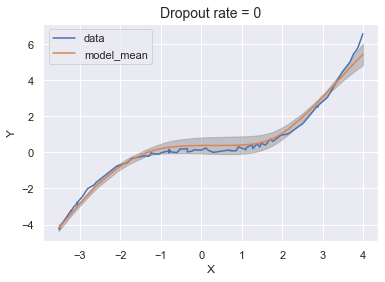

In [20]:
# plot 
# your code here 
model3_test_mean =model3_mean[x_test_order]
model3_test_sd  = model3_sd[x_test_order]

plt.plot(x_test, y_test, label = 'data')
plt.plot(x_test, model3_test_mean, label = 'model_mean')
plt.fill_between(x_test, model3_test_mean - model3_test_sd, 
                 model3_test_mean + model3_test_sd,
                 color='gray', alpha=0.4)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Dropout rate = 0', size = 14)
plt.legend()
plt.show()

**1.6** [2 pts] Compare both methods and discuss the pros and cons of each.


*Your answer here*

Dropout as a bayesian approximation:

- pros: computationally cheap as we fit one model and predict multiple times
- cons: underestimate variance severely, as we have the same training data for the model and drop part of the structure. This does not fully capture the uncertainty of training data.

bootstrap 

- pros: do not underestimate variance as we create different training data and get 'all' possible model structures to get distributions of predictions, so we capture uncertainty in training data and model structures
- cons: computationally expensive as we create multiple models